This is step 4. There 9 hardware shift positions. Data analysis: In each hardware shift position, there are 3 different repetitions. We conducts the training and testing like this: Use 3-validation by training 2 repetitions in all 9 hardware shifting and testing the rest repetetion in all 9 hardware shifting. But the hardware shift is every 1 step not half step.

1. Define necessary modules, class, functions

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
from encoder import Encoder as E
from helpers import set_cmd_cb, rms_formuula, get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

DEVICE = torch.device("cpu")
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

def rotate_batch(x, d, out_features):
    M = torch.diag(torch.ones(8)).roll(-1,1)
    used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]
    rotated = torch.empty(x.shape, device=DEVICE)
    for i in range (x.shape[0]):
        rotated[i] = used_bases[d[i]].matmul(x[i]) 
    return rotated

def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter

def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SINGLE CASE SHIFT 0 PROOF OF CONCEPT: train rep 1 at 9 hardware shifts and test rep 2 at 9 hardware shifts

2 Load Data: Data is 2 dimensions with order from outside: 3 folds, array data

In [4]:
subject = '22'

Fs = 1000
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

X_train = np.zeros([0, 8]) 
y_train = np.zeros([0])
X_test = np.zeros([0, 8])
y_test = np.zeros([0])


for shift in range(0,8): 
    for files in sorted(os.listdir(f'Subject_{subject}/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        
        df = pd.read_csv(f'Subject_{subject}/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
        data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
        data_arr -= 121
        data_arr /= 255.0
        feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
        
        if not class_.startswith('9'):
            rms_feature = feaData.sum(0)
            baseline = 2*rms_feature[-50:].mean()
            start_ = np.argmax(rms_feature[::1]>baseline)
            end_  = -np.argmax(rms_feature[::-1]>baseline)
            feaData = feaData.T[start_:end_]
        else:
            feaData = feaData.T
        
        
        if rep_.startswith(str(1)):
            X_test = np.concatenate([X_test,feaData])
            y_test = np.concatenate([y_test,np.ones_like(feaData)[:,0]*int(class_)-1])
        else:
            X_train = np.concatenate([X_train,feaData])
            y_train = np.concatenate([y_train,np.ones_like(feaData)[:,0]*int(class_)-1])


In [5]:
print("Training dataset feature:")
print(X_train.shape)
print("Training dataset label:")
print(y_train.shape)
print("Testing dataset feature:")
print(X_test.shape)
print("Testing dataset label:")
print(y_test.shape)

Training dataset feature:
(18906, 8)
Training dataset label:
(18906,)
Testing dataset feature:
(18851, 8)
Testing dataset label:
(18851,)


Logistic Regression

Training 

In [6]:
reg = LogisticRegression(penalty='l2', C=100).fit(X_train, y_train)
dump(reg, f'LogisticRegression_POC_22_s4.joblib')

['LogisticRegression_POC_22_s4.joblib']

Testing

In [7]:
logRegres  = load(f'LogisticRegression_POC_22_s4.joblib')
accuracy = logRegres.score(X_test,y_test)
print(accuracy)

0.4150973423160575


Confusion Matrix

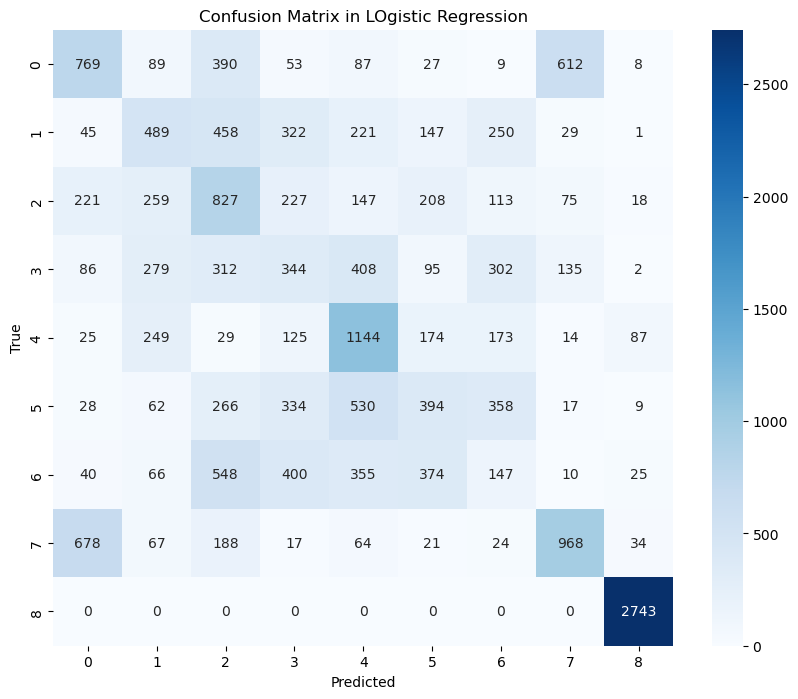

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
reg = load(f'LogisticRegression_POC_22_s4.joblib')

# Make predictions on the test data
predictions = reg.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix in LOgistic Regression')
plt.show()

Self-supervised Learning Model

In [9]:
all_X_train, all_y_train, all_shift_train = get_all_data(X_train, y_train)
all_X1_train, all_X2_train, all_shift_1_train, all_shift_2_train, all_y_shift_train = get_shift_data(all_X_train, all_shift_train, all_y_train)
traindataset = CustomSignalData(get_tensor(X_train), get_tensor(y_train))
#testdataset = CustomSignalData(get_tensor(X_test), get_tensor(y_test))

trainloader = torch.utils.data.DataLoader(traindataset, batch_size = 1, shuffle=True)
#testloader = torch.utils.data.DataLoader(testdataset, batch_size=24, shuffle=True)

all_train_dataset = CustomSignalData(get_tensor(all_X_train), get_tensor(all_y_train))
alltrainloader = torch.utils.data.DataLoader(all_train_dataset, batch_size = 102, shuffle=True)

triplet_train_dataset = CustomSignalData1(get_tensor(all_X1_train), get_tensor(all_X2_train), get_tensor(all_shift_1_train), get_tensor(all_shift_2_train), get_tensor(all_y_shift_train))
triplettrainloader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size = 102, shuffle=True)

Training

In [10]:
encoder = E(8,8)
encoder.to(DEVICE)
classifier = FFNN(8,9)
classifier.to(DEVICE)

parameters = list(encoder.parameters()) + list(classifier.parameters())

crit1 = torch.nn.MSELoss()
crit2 = torch.nn.CrossEntropyLoss()
crit1.to(DEVICE)
crit2.to(DEVICE)
loss_record = []

optimizer = torch.optim.Adam(parameters, lr=0.002)
n_epochs = 50

for epoch in range(0,n_epochs):
    encoder.train()
    classifier.train()
    for inputs1, inputs2, shift1, shift2, labels, _ in triplettrainloader:
        inputs1 = inputs1.to(DEVICE)
        inputs2 = inputs2.to(DEVICE)
        shift1 = -shift1.int().flatten().to(DEVICE)
        shift2 = -shift2.int().flatten().to(DEVICE)
        labels = labels.long().flatten().to(DEVICE)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y1 = encoder(inputs1)
        y_tr_est1 = rotate_batch(y1,shift1,6)
        y_tr1 = classifier(y_tr_est1)


        y2 = encoder(inputs2)
        y_tr_est2 = rotate_batch(y2,shift2,6)
        y_tr2 = classifier(y_tr_est2)

        loss =  crit1(y_tr_est1, y_tr_est2) + 0.5*crit2(y_tr1,labels)+ 0.5*crit2(y_tr2,labels)
        loss.backward()
        optimizer.step()

torch.save(classifier.state_dict(), f"classifier_POC_22_s4.pt")
torch.save(encoder.state_dict(), f"encoder_POC_22_s4.pt")
with torch.no_grad():
    encoder.eval()
    N_points = 1000
    rand_idx = np.random.choice(all_X_train.shape[0], N_points)
    y_tr = encoder(get_tensor(all_X_train[rand_idx]))
    recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
    del y_tr

torch.save(recovered_points_, f"reference_points_POC_22_s4.pt")

Testing

In [11]:
DEVICE = torch.device("cpu") # operations is in CPU or GPU.
M = torch.diag(torch.ones(8)).roll(-1,1) # Create a diagnoise matrix then shift it to the right
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)] #

N_points = 1000


classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
encoder = E(8,8)
encoder.load_state_dict(torch.load(f"encoder_POC_22_s4.pt")) # contains the learned parameters (weights and biases) of the encoder model
recovered_points_= torch.load(f"reference_points_POC_22_s4.pt") # These points represent reference points for inference or evaluation in the model
classifier.load_state_dict(torch.load(f"classifier_POC_22_s4.pt")) # contains the weights and biases learned during training.
classifier.eval() # sets the model to evaluation mode.
encoder.eval() # sets the model to evaluation mode.

# Get the test data for the current shift and fold
X_test_shift = X_test

# Encode the test data using the encoder model
y1 = encoder(get_tensor(X_test_shift))

# Use the encoded data directly without rotation
y_tr1 = classifier(y1).argmax(1)

# Calculate accuracy and append to list
accuracies_self_supervised = (1 - torch.abs(torch.sign(y_tr1 - get_tensor(y_test).flatten()))).mean().item()

print(accuracies_self_supervised)

0.5560978055000305


Confusion matrix

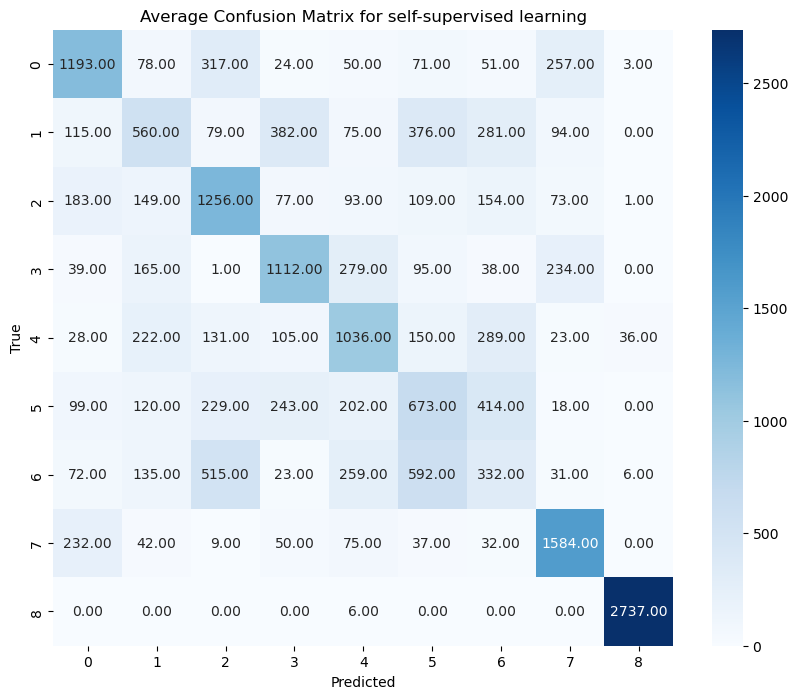

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
encoder = E(8,8)
encoder.load_state_dict(torch.load(f"encoder_POC_22_s4.pt")) # contains the learned parameters (weights and biases) of the encoder model
recovered_points_= torch.load(f"reference_points_POC_22_s4.pt") # These points represent reference points for inference or evaluation in the model
classifier.load_state_dict(torch.load(f"classifier_POC_22_s4.pt")) # contains the weights and biases learned during training.
classifier.eval() # sets the model to evaluation mode.
encoder.eval() # sets the model to evaluation mode.

# Get the test data for the current shift and fold
X_test_shift = X_test
# Encode the test data using the encoder model
y1 = encoder(get_tensor(X_test_shift))
# Use the encoded data directly without rotation
y_tr1 = classifier(y1).argmax(1)


# Calculate the confusion matrix for the current shift
conf_matrix = confusion_matrix(get_tensor(y_test).flatten(), y_tr1.cpu().numpy())


# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Average Confusion Matrix for self-supervised learning')
plt.show()

SINGLE CASE SHIFT 0 PROOF OF CONCEPT: train 2 reps in shift hardware 0 and test 2 reps in rest 8 hardware shifts

In [14]:
subject = '22'

Fs = 1000
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

X_train = np.zeros([0, 8]) 
y_train = np.zeros([0])
X_test = np.zeros([0, 8])
y_test = np.zeros([0])


for shift in range(0,8): 
    for files in sorted(os.listdir(f'Subject_{subject}/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        
        df = pd.read_csv(f'Subject_{subject}/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
        data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
        data_arr -= 121
        data_arr /= 255.0
        feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
        
        if not class_.startswith('9'):
            rms_feature = feaData.sum(0)
            baseline = 2*rms_feature[-50:].mean()
            start_ = np.argmax(rms_feature[::1]>baseline)
            end_  = -np.argmax(rms_feature[::-1]>baseline)
            feaData = feaData.T[start_:end_]
        else:
            feaData = feaData.T
        
        
        if shift != 0:
            X_test = np.concatenate([X_test,feaData])
            y_test = np.concatenate([y_test,np.ones_like(feaData)[:,0]*int(class_)-1])
        else:
            X_train = np.concatenate([X_train,feaData])
            y_train = np.concatenate([y_train,np.ones_like(feaData)[:,0]*int(class_)-1])


In [15]:
print("Training dataset feature:")
print(X_train.shape)
print("Training dataset label:")
print(y_train.shape)
print("Testing dataset feature:")
print(X_test.shape)
print("Testing dataset label:")
print(y_test.shape)

Training dataset feature:
(4806, 8)
Training dataset label:
(4806,)
Testing dataset feature:
(32951, 8)
Testing dataset label:
(32951,)


Logistic Regression

In [16]:
reg = LogisticRegression(penalty='l2', C=100).fit(X_train, y_train)
dump(reg, f'LogisticRegression_POC_22_s4_2.joblib')

/home/eea-10/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['LogisticRegression_POC_22_s4_2.joblib']

Testing

In [17]:
logRegres  = load(f'LogisticRegression_POC_22_s4_2.joblib')
accuracy = logRegres.score(X_test,y_test)
print(accuracy)

0.23286091469151163


Confusion matrix

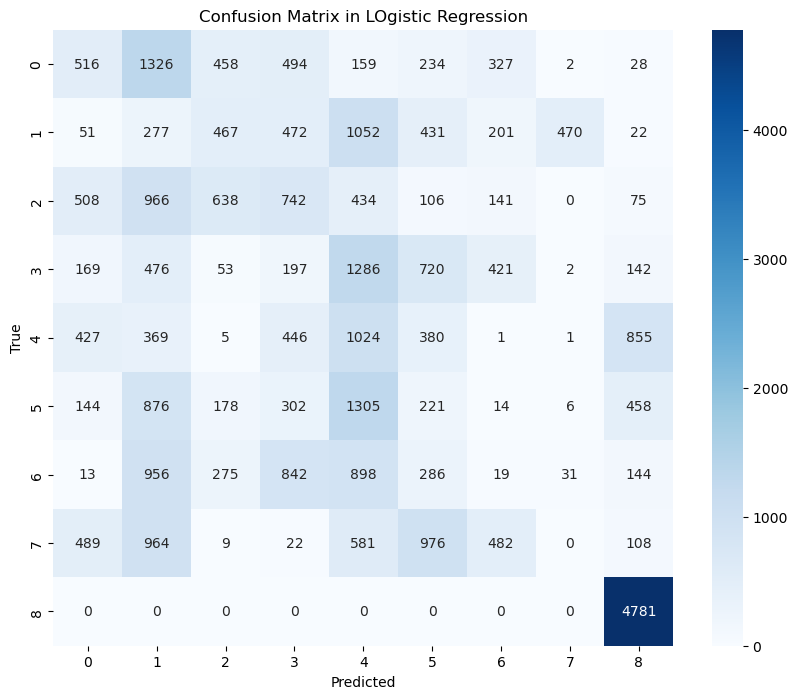

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
reg = load(f'LogisticRegression_POC_22_s4_2.joblib')

# Make predictions on the test data
predictions = reg.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix in LOgistic Regression')
plt.show()

Self-supervised Learning Model

In [19]:
all_X_train, all_y_train, all_shift_train = get_all_data(X_train, y_train)
all_X1_train, all_X2_train, all_shift_1_train, all_shift_2_train, all_y_shift_train = get_shift_data(all_X_train, all_shift_train, all_y_train)
traindataset = CustomSignalData(get_tensor(X_train), get_tensor(y_train))
#testdataset = CustomSignalData(get_tensor(X_test), get_tensor(y_test))

trainloader = torch.utils.data.DataLoader(traindataset, batch_size = 1, shuffle=True)
#testloader = torch.utils.data.DataLoader(testdataset, batch_size=24, shuffle=True)

all_train_dataset = CustomSignalData(get_tensor(all_X_train), get_tensor(all_y_train))
alltrainloader = torch.utils.data.DataLoader(all_train_dataset, batch_size = 102, shuffle=True)

triplet_train_dataset = CustomSignalData1(get_tensor(all_X1_train), get_tensor(all_X2_train), get_tensor(all_shift_1_train), get_tensor(all_shift_2_train), get_tensor(all_y_shift_train))
triplettrainloader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size = 102, shuffle=True)

Training

In [20]:
encoder = E(8,8)
encoder.to(DEVICE)
classifier = FFNN(8,9)
classifier.to(DEVICE)

parameters = list(encoder.parameters()) + list(classifier.parameters())

crit1 = torch.nn.MSELoss()
crit2 = torch.nn.CrossEntropyLoss()
crit1.to(DEVICE)
crit2.to(DEVICE)
loss_record = []

optimizer = torch.optim.Adam(parameters, lr=0.002)
n_epochs = 50

for epoch in range(0,n_epochs):
    encoder.train()
    classifier.train()
    for inputs1, inputs2, shift1, shift2, labels, _ in triplettrainloader:
        inputs1 = inputs1.to(DEVICE)
        inputs2 = inputs2.to(DEVICE)
        shift1 = -shift1.int().flatten().to(DEVICE)
        shift2 = -shift2.int().flatten().to(DEVICE)
        labels = labels.long().flatten().to(DEVICE)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y1 = encoder(inputs1)
        y_tr_est1 = rotate_batch(y1,shift1,6)
        y_tr1 = classifier(y_tr_est1)


        y2 = encoder(inputs2)
        y_tr_est2 = rotate_batch(y2,shift2,6)
        y_tr2 = classifier(y_tr_est2)

        loss =  crit1(y_tr_est1, y_tr_est2) + 0.5*crit2(y_tr1,labels)+ 0.5*crit2(y_tr2,labels)
        loss.backward()
        optimizer.step()

torch.save(classifier.state_dict(), f"classifier_POC_22_s4_2.pt")
torch.save(encoder.state_dict(), f"encoder_POC_22_s4_2.pt")
with torch.no_grad():
    encoder.eval()
    N_points = 1000
    rand_idx = np.random.choice(all_X_train.shape[0], N_points)
    y_tr = encoder(get_tensor(all_X_train[rand_idx]))
    recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
    del y_tr

torch.save(recovered_points_, f"reference_points_POC_22_s4_2.pt")

Testing

In [21]:
DEVICE = torch.device("cpu") # operations is in CPU or GPU.
M = torch.diag(torch.ones(8)).roll(-1,1) # Create a diagnoise matrix then shift it to the right
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)] #

N_points = 1000


classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
encoder = E(8,8)
encoder.load_state_dict(torch.load(f"encoder_POC_22_s4_2.pt")) # contains the learned parameters (weights and biases) of the encoder model
recovered_points_= torch.load(f"reference_points_POC_22_s4_2.pt") # These points represent reference points for inference or evaluation in the model
classifier.load_state_dict(torch.load(f"classifier_POC_22_s4_2.pt")) # contains the weights and biases learned during training.
classifier.eval() # sets the model to evaluation mode.
encoder.eval() # sets the model to evaluation mode.

# Get the test data for the current shift and fold
X_test_shift = X_test

# Encode the test data using the encoder model
y1 = encoder(get_tensor(X_test_shift))

# Use the encoded data directly without rotation
y_tr1 = classifier(y1).argmax(1)

# Calculate accuracy and append to list
accuracies_self_supervised = (1 - torch.abs(torch.sign(y_tr1 - get_tensor(y_test).flatten()))).mean().item()

print(accuracies_self_supervised)

0.2103426307439804


Confusion matrix

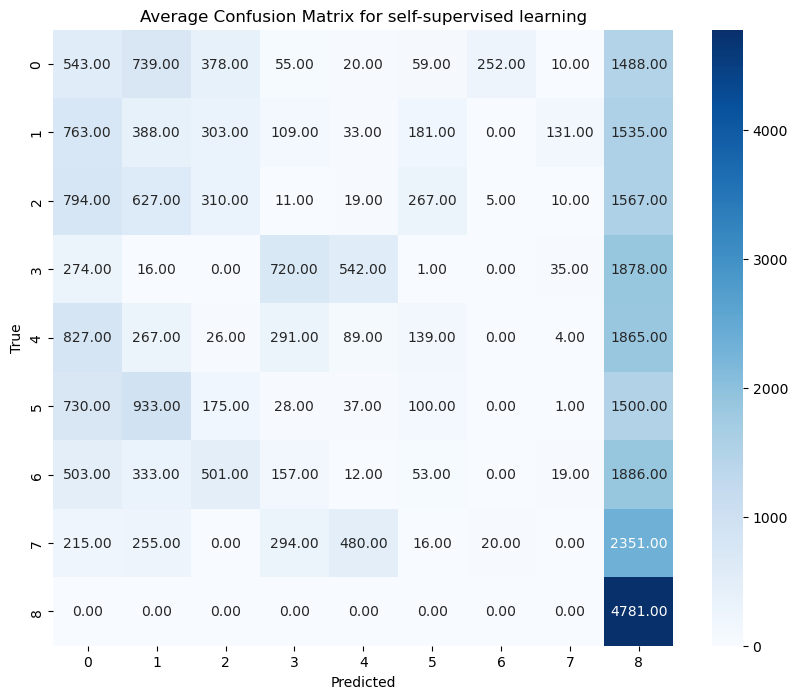

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
encoder = E(8,8)
encoder.load_state_dict(torch.load(f"encoder_POC_22_s4_2.pt")) # contains the learned parameters (weights and biases) of the encoder model
recovered_points_= torch.load(f"reference_points_POC_22_s4_2.pt") # These points represent reference points for inference or evaluation in the model
classifier.load_state_dict(torch.load(f"classifier_POC_22_s4_2.pt")) # contains the weights and biases learned during training.
classifier.eval() # sets the model to evaluation mode.
encoder.eval() # sets the model to evaluation mode.

# Get the test data for the current shift and fold
X_test_shift = X_test
# Encode the test data using the encoder model
y1 = encoder(get_tensor(X_test_shift))
# Use the encoded data directly without rotation
y_tr1 = classifier(y1).argmax(1)


# Calculate the confusion matrix for the current shift
conf_matrix = confusion_matrix(get_tensor(y_test).flatten(), y_tr1.cpu().numpy())


# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Average Confusion Matrix for self-supervised learning')
plt.show()